In [1]:
# IMPORTS
import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

# Downloading data

In [2]:
### API
binance_api_key = '0YoXpNjk2J0rwPmIDFlgRuu2fFHKHSADD6qUNoRVTr3N9Rddjdbg3AFP7jzyxvly'    #Enter your own API-key here
binance_api_secret = 'rKJZ8XQZGI4D9lTmYztoHmTDPw4fWcNWbT4vEs6edw8qEmBP4QqAYfBmxH6KGWiW' #Enter your own API-secret here

In [3]:
### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
client = Client(binance_api_key)

In [4]:
### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  
        old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": 
        old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    if source == "binance": 
        new = pd.to_datetime(
            client.get_klines(symbol=symbol, 
                                      interval=kline_size)[-1][0], 
            unit='ms'
        )
    return old, new

In [5]:
def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): 
        data_df = pd.read_csv(filename)
    else: 
        data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, 
                                                     kline_size, 
                                                     data_df, 
                                                     source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): 
        print('Downloading all available %s data for %s. \
        Be patient..!' % (kline_size, symbol))
    else: 
        print('Downloading %d minutes of new data available \
        for %s, i.e. %d instances of %s data.' \
              % (delta_min, symbol, available_data, kline_size))
    klines = client.get_historical_klines(symbol, 
                                          kline_size, 
                                          oldest_point.strftime("%d %b %Y %H:%M:%S"), 
                                          newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, 
                        columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                                   'close_time', 'quote_av', 'trades', 'tb_base_av', 
                                   'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: 
        data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: 
        data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [6]:
def get_delta_binance(symbol, kline_size, save = False, delta=timedelta(days=7)):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, 
                                                     kline_size, 
                                                     data_df, 
                                                     source = "binance")
    oldest_point = newest_point - delta
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    print('Downloading %d minutes of new data available \
    for %s, i.e. %d instances of %s data.' \
          % (delta_min, symbol, available_data, kline_size))
    klines = client.get_historical_klines(symbol, 
                                          kline_size, 
                                          oldest_point.strftime("%d %b %Y %H:%M:%S"), 
                                          newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, 
                        columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                                   'close_time', 'quote_av', 'trades', 'tb_base_av', 
                                   'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: 
        data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: 
        data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [7]:
data = get_delta_binance("BTCUSDT", '1m', save = True, delta=timedelta(days=14))

All caught up..!


# Analysing

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
df = pd.read_csv("BTCUSDT-1m-data.csv")
df.head()

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
0,2021-07-04 18:51:00,35475.86,35486.49,35470.57,35485.45,6.507523,1625424719999,2.308892e+05,297,3.019595,107132.595848,0
1,2021-07-04 18:52:00,35485.45,35489.98,35478.59,35481.50,9.580729,1625424779999,3.399682e+05,306,4.968406,176304.670780,0
2,2021-07-04 18:53:00,35481.50,35500.00,35470.75,35499.68,15.369071,1625424839999,5.454286e+05,455,7.694150,273075.902500,0
3,2021-07-04 18:54:00,35499.68,35524.99,35495.00,35522.15,29.275888,1625424899999,1.039711e+06,650,21.447608,761691.157588,0
4,2021-07-04 18:55:00,35522.15,35530.00,35511.22,35515.31,16.722982,1625424959999,5.940260e+05,382,6.649400,236209.669217,0


In [6]:
ts = [datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in df.timestamp]

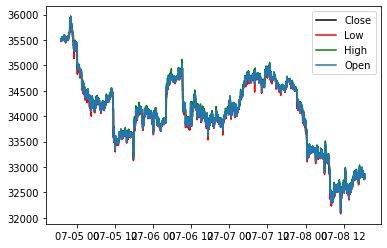

In [7]:
plt.plot(ts, df.close, "black", label="Close")
plt.plot(ts, df.low, "red", label="Low")
plt.plot(ts, df.high, "green", label="High")
plt.plot(ts, df.open, label="Open")

plt.legend()

In [72]:
data = pd.read_csv("BTCUSDT-1m-data.csv")

df = data[["timestamp", "open", "high", "low", "close"]].rename({"timestamp":"Date", "open":"Open", "high":"High", "low":"Low", "close":"Close"}, axis='columns')

In [74]:
df.set_index("Date")

,Open,High,Low,Close
Date,,,,
2021-07-04 18:51:00,35475.86,35486.49,35470.57,35485.45
2021-07-04 18:52:00,35485.45,35489.98,35478.59,35481.50
2021-07-04 18:53:00,35481.50,35500.00,35470.75,35499.68
2021-07-04 18:54:00,35499.68,35524.99,35495.00,35522.15
2021-07-04 18:55:00,35522.15,35530.00,35511.22,35515.31
...,...,...,...,...
2021-07-08 18:47:00,32853.49,32856.25,32850.01,32850.01
2021-07-08 18:48:00,32850.02,32856.78,32776.30,32787.96
2021-07-08 18:49:00,32787.97,32794.88,32766.85,32782.22
